## Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt


## Load Train Data

In [ ]:
train_set = datasets.MNIST(root='../mnist_data', train=True,  download=True)
test_set = datasets.MNIST(root='../mnist_data', train=False, download=True)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([])

class custom_mnist(Dataset):
    def __init__(self, input_data):
        super().__init__()
        self.data = input_data
        

    def __getitem__(self, idx):
        return torch.stack([torch.FloatTensor(np.array(transform(self.data[idx][0])) > 0)])

    def __len__(self):
        return len(self.data)

In [4]:
mnist_train = custom_mnist(train_set)
mnist_test = custom_mnist(test_set)

train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=128)

## Visualise original images

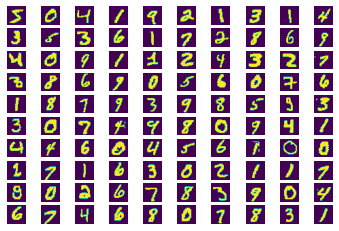

In [5]:
f, axarr = plt.subplots(10,10)

for i in range(10):
    for j in range(10):
        axarr[i,j].imshow(mnist_train[10*i + j][0])
        axarr[i,j].axis('off')

## Masked Convolutional 2D layer

In [6]:
'''
mask_type A -> R dependent on (context), G dependent on (context,R) , B dependent on (context,R,G )-> used in first layer
mask_type B -> R dependent on (context,R), G dependent on (context,R,G) , B dependent on (context,R,G,B)-> used in layers except first
'''


'''
consider color = True , if 3 independent color channels - RGB are provided as input
'''

class MaskedConv2D(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, mask_type, consider_color):
        super().__init__(in_channels, out_channels, kernel_size, stride, padding)
        self.register_buffer('mask', torch.zeros_like(self.weight))

        self.stride = stride
        self.pad = padding
        self.consider_color = consider_color

        inp = in_channels//3
        out = out_channels//3
        k = kernel_size//2

        self.mask[:,:,:k] = 1
        self.mask[:,:,k,:k] = 1


        if self.consider_color:
            if mask_type == 'A':
                self.mask[out:2*out, :inp, k,k] = 1
                self.mask[2*out: , :2*inp, k, k] = 1

            if mask_type == 'B':
                self.mask[:out, :inp, k,k] = 1
                self.mask[out:2*out, :2*inp, k,k] = 1
                self.mask[2*out:, :, k,k] = 1
        else:
            if mask_type == 'B':
                self.mask[:, :, k,k] = 1
                

    def forward(self,x):
        return F.conv2d(x,self.weight * self.mask, self.bias, self.stride, self.pad)



## Residual Block

In [7]:

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, color):
        super().__init__()
        self.inp = in_channels
        self.color = color

        self.net = nn.Sequential(
            MaskedConv2D(self.inp , self.inp//2 , 1,  1, 0, 'B',self.color ),
            nn.ReLU(), 
            MaskedConv2D(self.inp//2 , self.inp//2 , 7,  1, 3, 'B',self.color ),
            nn.ReLU(), 
            MaskedConv2D(self.inp//2 , self.inp , 1,  1, 0, 'B',self.color ),
            nn.ReLU()
        )
    
    def forward(self,x):
        return (x + self.net(x))

## Pixel CNN Architecture

In [8]:
# num_features = number of activation maps 
# num_layers = number of residual blocks to add
# kernel_size = kernel size for the first layer
# num_channel = number of channels in input image
# d = number of distict values a pixel can take (id d == 2, passing it as 1 also works)

class PixelCNN(nn.Module):
    def __init__(self, num_layers, num_features,kernel_size, num_channel, d,color, use_residual ):
        super().__init__()

        self.net = nn.ModuleList()
        self.color = color
        
        
        self.net.append(MaskedConv2D(num_channel,num_features, kernel_size, 1, kernel_size//2, 'A',self.color))
        self.net.append(nn.ReLU())

        for layer in range(num_layers):
            if use_residual:
                self.net.append(ResidualBlock(num_features,self.color))
            else:
                self.net.append(MaskedConv2D(num_features,num_features,kernel_size,1,kernel_size//2,'B',self.color))
                self.net.append(nn.ReLU())
            

        
        self.net.append(MaskedConv2D(num_features,num_features,1,1,0,'B',self.color))
        self.net.append(nn.ReLU())
        self.net.append(MaskedConv2D(num_features,num_channel*d,1,1,0,'B',self.color))

        self.net = nn.Sequential(*self.net)


    def forward (self,x):
        return (self.net(x))




## Training Procedure

In [ ]:
model = PixelCNN(5,64,7,1,1,False,True).to(device)
optimizer = Adam(model.parameters(), lr = 0.001)
criterion = nn.BCEWithLogitsLoss()
num_epochs = 8
train_loss_hist = []
valid_loss_hist = []

for epoch in range(num_epochs):

    valid_loss = 0
    for idx, valid_data in (enumerate(test_loader)):
        data = valid_data.to(device)

        with torch.no_grad():
            pred = model(data)

        loss = criterion(pred, data)
        valid_loss += loss

    valid_loss_hist.append(valid_loss/idx)

    for idx, train_data in tqdm(enumerate(train_loader)):
        data = train_data.to(device)
        
        pred = model(data)

        loss = criterion(pred, data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_hist.append(loss)

    

plt.plot(train_loss_hist)
plt.show()
plt.plot(valid_loss_hist)

## Sample for new image generation

In [15]:
def sample(model, num_samples, num_channels, h,w):
    out = torch.zeros(num_samples, num_channels, h, w)

    for i in range(h):
        for j in range(w):
            with torch.no_grad():
                sample = model(out.to(device))
            sample = torch.bernoulli(torch.sigmoid(sample))
            out[:,:,i,j] = sample[:,:,i,j]

    return out.detach()


In [18]:
out = sample(model, 100, 1, 28,28)

In [ ]:
f, axarr = plt.subplots(10,10)
for i in range(10):
    for j in range(10):
        axarr[i,j].imshow(out[10*i + j][0])
        axarr[i,j].axis('off')
